# Set-up the environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MLEARN/Competition
!ls

/content/drive/MyDrive/MLEARN/Competition
checkpoints		   grid_search_df_2.csv		 Predictions
dataset_test_no_label.csv  grid_search_df.csv		 script.ipynb
dataset_train.csv	   ML_Lab10_guide_Tar2023v1.pdf  training_results.pkl


# Importing and preparing the dataset

In [4]:
import pandas as pd

file_path = 'dataset_train.csv'
data = pd.read_csv(file_path, header=None, index_col=0)

new_column_names = [f'V{i}' for i in range(257)] + ['Class']
data.columns = new_column_names

## Exploratory Data Analysis

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9600 entries, 0 to 9599
Columns: 258 entries, V0 to Class
dtypes: float64(256), int64(1), object(1)
memory usage: 19.0+ MB


In [7]:
print(f'Dataset dimension: {data.shape}\n')
display(data[['V0', 'V1', 'V2', 'V255', 'V256', 'Class']].head(10))

Dataset dimension: (9600, 258)



,V0,V1,V2,V255,V256,Class
0,,,,,,
0,0.006577,0.006838,0.006922,-0.005133,16,GFSK
1,0.004386,0.004399,0.004373,-0.006558,16,AM-DSB
2,0.008028,0.008146,0.008143,-0.007177,10,GFSK
3,0.006378,0.006394,0.005967,-0.006250,10,BPSK
4,0.005806,0.005824,0.005830,0.003019,16,GFSK
5,0.005483,0.003825,0.002153,0.005606,10,QPSK
6,0.003415,0.003153,0.003042,-0.007623,10,AM-DSB
7,-0.009339,-0.009818,-0.009999,-0.004752,10,QPSK
8,0.001911,0.002166,0.002140,-0.005969,18,GFSK


In [10]:
data[['V0', 'V1', 'V2', 'V255', 'V256', 'Class']].describe()

,V0,V1,V2,V255,V256
count,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000
mean,0.000420,0.000423,0.000415,-0.001244,14.650417
std,0.005210,0.005211,0.005231,0.006469,3.398626
min,-0.012790,-0.012615,-0.016232,-0.076820,10.000000
25%,-0.003868,-0.003867,-0.003918,-0.007023,10.000000
50%,0.000943,0.000940,0.000941,-0.002379,16.000000
75%,0.004698,0.004695,0.004695,0.004264,18.000000
max,0.012795,0.012687,0.018927,0.164229,18.000000


In [9]:
class_counts = data['Class'].value_counts()
class_counts

Class
GFSK      2440
AM-DSB    2388
QPSK      2388
BPSK      2384
Name: count, dtype: int64

The dataset is balanced

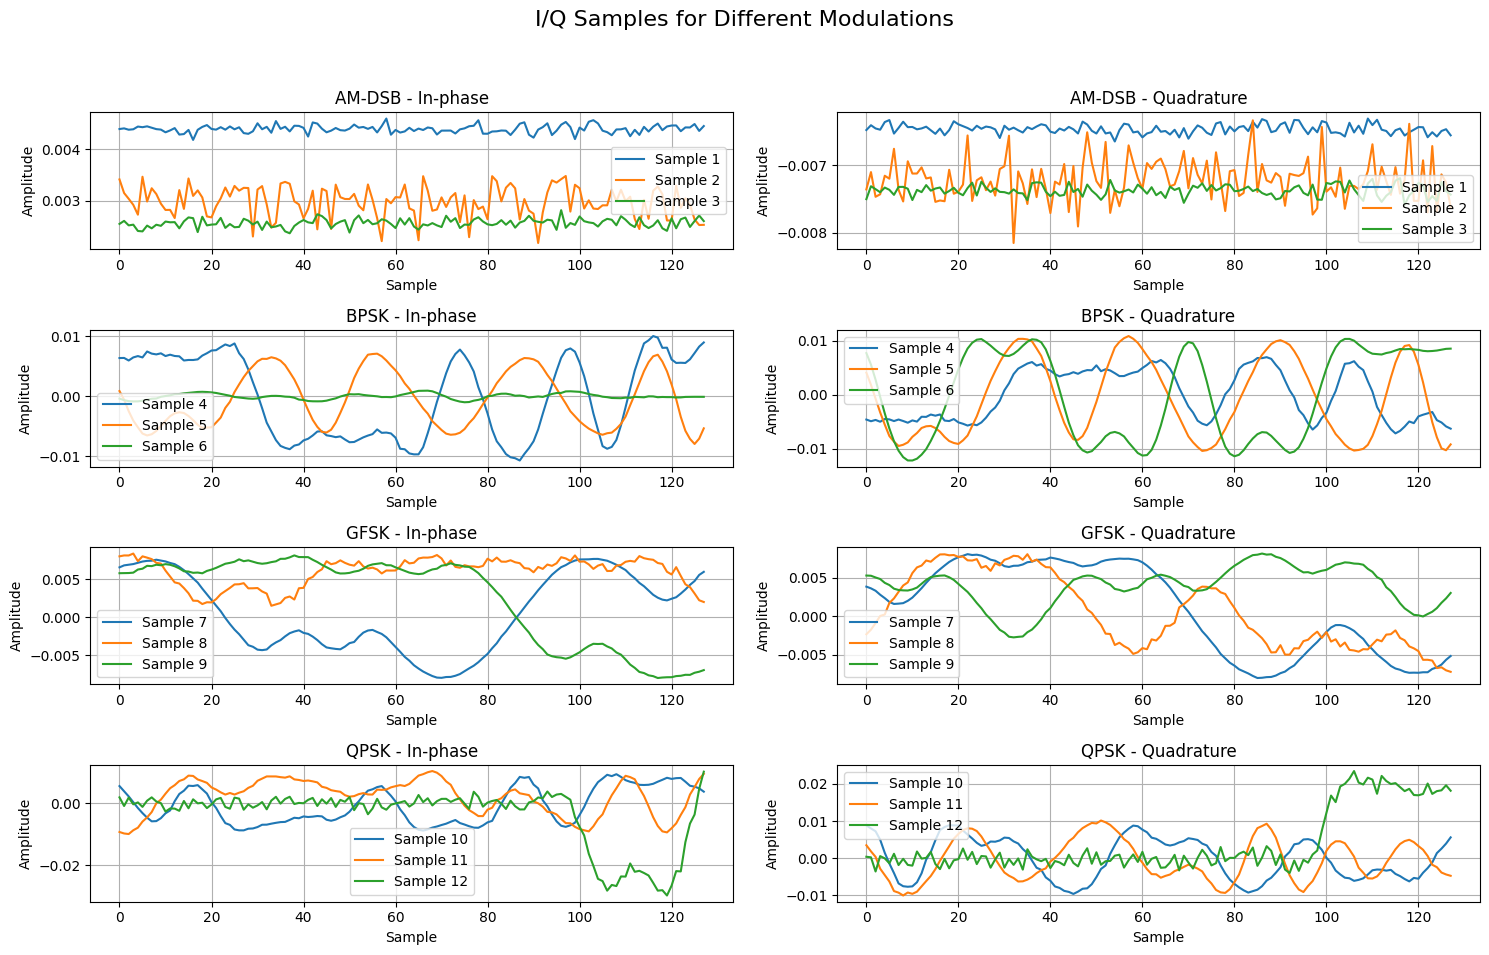

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Selecting a few examples from each modulation type
sample_data = data.groupby('Class').apply(lambda x: x.head(3)).reset_index(drop=True)

# Plotting I/Q samples for these selected examples
fig, axes = plt.subplots(sample_data['Class'].nunique(), 2, figsize=(15, 10))
fig.suptitle('I/Q Samples for Different Modulations', fontsize=16)

for i, modulation in enumerate(sample_data['Class'].unique()):
    modulation_data = sample_data[sample_data['Class'] == modulation]

    for j, row in modulation_data.iterrows():
        in_phase = row.iloc[:128].values
        quadrature = row.iloc[128:256].values
        time = np.arange(len(in_phase))  # Time axis

        axes[i, 0].plot(time, in_phase, label=f'Sample {j+1}')
        axes[i, 1].plot(time, quadrature, label=f'Sample {j+1}')

    axes[i, 0].set_title(f'{modulation} - In-phase')
    axes[i, 0].set_xlabel('Sample')
    axes[i, 0].set_ylabel('Amplitude')
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    axes[i, 1].set_title(f'{modulation} - Quadrature')
    axes[i, 1].set_xlabel('Sample')
    axes[i, 1].set_ylabel('Amplitude')
    axes[i, 1].legend()
    axes[i, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Machine Learning Methods

## Prepare the dataset

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Encoding the modulation labels
le = LabelEncoder()
data_encoded = data.copy()
data_encoded['Class_enc'] = le.fit_transform(data_encoded['Class'])

In [ ]:
# Separating features and target label
X = data.iloc[:, :-1]
y = le.transform(data.iloc[:, 257])

Training set dimension: (8160, 257)
Validation set dimension: (1440, 257)


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Support Vector Machines 

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Preparazione del classificatore SVM
svm = SVC()

# Definizione dei parametri per GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Creazione di GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=5, verbose=2, n_jobs=-1, scoring='accuracy', return_train_score=True)

# Addestramento del modello
grid_search.fit(X, y)

# Stampa dei migliori parametri
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}\n")

results = pd.DataFrame(grid_search.cv_results_)
display(results[['param_C', 'param_gamma', 'param_kernel', 'mean_train_score', 'mean_test_score']])

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time= 1.1min
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time= 1.1min
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time= 1.1min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.2min
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time= 1.0min
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time= 1.0min
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time= 1.1min
[CV] END .................C=0.1, gamma=scale, k

,param_C,param_gamma,param_kernel,mean_train_score,mean_test_score
0,0.1,scale,rbf,0.254167,0.254167
1,0.1,scale,poly,0.254792,0.250625
2,0.1,scale,sigmoid,0.254167,0.254167
3,0.1,auto,rbf,0.254167,0.254167
4,0.1,auto,poly,0.254792,0.250625
5,0.1,auto,sigmoid,0.254167,0.254167
6,1,scale,rbf,0.254792,0.250625
7,1,scale,poly,0.254792,0.250625
8,1,scale,sigmoid,0.251667,0.251771
9,1,auto,rbf,0.254792,0.250625


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Preparazione del classificatore Random Forest
rf = RandomForestClassifier()

# Definizione dei parametri per GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Numero di alberi nella foresta
    'max_depth': [None, 10, 20, 30],  # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10],  # Numero minimo di campioni necessari per dividere un nodo
    'min_samples_leaf': [1, 2, 4]  # Numero minimo di campioni richiesti a livello di foglia
}

# Creazione di GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=5, verbose=2, n_jobs=-1, scoring='accuracy', return_train_score=True)

# Addestramento del modello
grid_search.fit(X, y)

# Stampa dei migliori parametri
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}\n")

# Visualizzazione dei risultati
results = pd.DataFrame(grid_search.cv_results_)
display(results[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_train_score', 'mean_test_score']])

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   3.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   3.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   3.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   3.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   3.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  13.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  14.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  14.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  13.8s
[CV] END max_depth=

,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_train_score,mean_test_score
0,10,None,2,1,0.998203,0.903958
1,50,None,2,1,1.000000,0.940833
2,100,None,2,1,1.000000,0.944583
3,200,None,2,1,1.000000,0.943750
4,10,None,5,1,0.997161,0.910000
...,...,...,...,...,...,...
139,200,30,5,4,0.998958,0.933437
140,10,30,10,4,0.985339,0.906042
141,50,30,10,4,0.996927,0.929167
142,100,30,10,4,0.998359,0.932604


In [ ]:
riga_max_accuracy = results[results['mean_test_score'] == results['mean_test_score'].max()]
display(riga_max_accuracy[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_train_score', 'mean_test_score']])

,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_train_score,mean_test_score
2,100,None,2,1,1.0,0.944583


# Deep Learning Methods

## Prepare the train and validation datasets

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Encoding the modulation labels
le = LabelEncoder()
data_encoded = data.copy()
data_encoded['Class_enc'] = le.fit_transform(data_encoded['Class'])

In [ ]:
# Separating features and target label
X = data.iloc[:, :-1]
y = le.transform(data.iloc[:, 257])

# Splitting the dataset into training (80%) and testing (15%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)
print(f'Training set dimension: {X_train.shape}')
print(f'Validation set dimension: {X_val.shape}')

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

Training set dimension: (7680, 257)
Validation set dimension: (1920, 257)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device in use: {device}')

# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Creating TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

Device in use: cuda


## Attempt 1: Fully-Connected Network 

- Number of layers: 6
- Structure: 512-256-128-64-32-4

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

class ModulationClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ModulationClassifier, self).__init__()
        self.fc1 = nn.Linear(X_train_scaled.shape[1], 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc6 = nn.Linear(32, len(le.classes_))

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = F.leaky_relu(self.bn3(self.fc3(x)))
        x = F.leaky_relu(self.bn4(self.fc4(x)))
        x = self.dropout(F.leaky_relu(self.bn5(self.fc5(x))))
        x = self.fc6(x)
        return x

#### Tried different seeds to evaluate the average performance over multiple initialization.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(seed, device, train_loader, val_loader, model_name, version, num_epochs):
    # Set the seed
    torch.manual_seed(seed)

    # Instantiate the model, loss function, and optimizer
    model = ModulationClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    best_accuracy = 0
    best_ckpt = f'checkpoints/Checkpoint_{model_name}_v{version}_{seed}.pt'
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(train_loader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Evaluating the Model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch[0].to(device), batch[1].to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total

        if best_accuracy < accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), best_ckpt)

        if (epoch+1)%5 == 0 or epoch == 0:
            print(f"[Epoch {epoch+1:>{len(str(num_epochs))}}/{num_epochs}] "
                  f"Loss: {running_loss/len(train_loader):.8f} | "
                  f"Accuracy: {accuracy:.4f}")

In [ ]:
seeds = [1, 12, 123, 1234, 12345, 123456, 1234567, 12345678, 123456789, 1234567890]

for it, seed in enumerate(seeds):
    print(f'\n[{it+1}/{len(seeds)}]')
    train_model(seed, device, train_loader, val_loader, 'Linear', '5', 60)


[1/10]
[Epoch  1/60] Loss: 0.88496293 | Accuracy: 0.7583
[Epoch  5/60] Loss: 0.23158201 | Accuracy: 0.8948
[Epoch 10/60] Loss: 0.09378532 | Accuracy: 0.9615
[Epoch 15/60] Loss: 0.04002608 | Accuracy: 0.9646
[Epoch 20/60] Loss: 0.02649858 | Accuracy: 0.9833
[Epoch 25/60] Loss: 0.03658910 | Accuracy: 0.9698
[Epoch 30/60] Loss: 0.02353161 | Accuracy: 0.9833
[Epoch 35/60] Loss: 0.02694890 | Accuracy: 0.9875
[Epoch 40/60] Loss: 0.01468353 | Accuracy: 0.9823
[Epoch 45/60] Loss: 0.03436909 | Accuracy: 0.9792
[Epoch 50/60] Loss: 0.02106196 | Accuracy: 0.9823
[Epoch 55/60] Loss: 0.01690218 | Accuracy: 0.9865
[Epoch 60/60] Loss: 0.01182783 | Accuracy: 0.9875

[2/10]
[Epoch  1/60] Loss: 0.97428938 | Accuracy: 0.7479
[Epoch  5/60] Loss: 0.27705375 | Accuracy: 0.8750
[Epoch 10/60] Loss: 0.07632463 | Accuracy: 0.9552
[Epoch 15/60] Loss: 0.04469442 | Accuracy: 0.9750
[Epoch 20/60] Loss: 0.04705773 | Accuracy: 0.9823
[Epoch 25/60] Loss: 0.01964144 | Accuracy: 0.9833
[Epoch 30/60] Loss: 0.03795130 | A

#### Grid Search to optimize the parameters

- `lr`: [0.001, 0.0001]
- `batch_size`: [16, 32, 64, 128]
- `hidden_sizes`: : [512, 256, 128, 64, 32], [256, 128, 64, 32, 16], [128, 64, 32, 16, 8]
- `activation_func`: ['ReLu', 'LeakyReLU', 'Tanh']
- `optimizer_type`: ['adam', 'sgd']
- `scheduler`: ['step_size': 10, 'gamma': 0.03], ['step_size': 20, 'gamma': 0.2]
- `dropout`: [0, 0.3, 0.5]

In [ ]:
import torch.nn as nn
import torch.nn.init as init

class MyModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, activation_func, dropout):
        super(MyModel, self).__init__()
        self.activation_func = activation_func
        layers = []

        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            if activation_func == 'ReLu':
                layers.append(nn.ReLU())
            elif activation_func == 'Tanh':
                layers.append(nn.Tanh())
            elif activation_func == 'LeakyReLU':
                layers.append(nn.LeakyReLU())
            layers.append(nn.Dropout(dropout))

        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import itertools
from torch.optim.lr_scheduler import StepLR
import math

class Trainer:
    def __init__(self, model, train_loader, val_loader, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

    def train(self, model, optimizer, batch_size, num_epochs, scheduler_config):
        criterion = nn.CrossEntropyLoss()
        scheduler = StepLR(optimizer, step_size=scheduler_config['step_size'], gamma=scheduler_config['gamma'])

        best_accuracy = 0
        train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            scheduler.step()

            train_loss = running_loss / len(self.train_loader)
            train_accuracy = correct / total
            test_loss, test_accuracy = self.validate(model, criterion)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)

            if best_accuracy < test_accuracy:
                best_accuracy = test_accuracy

            if (epoch+1)%10 == 0 or epoch == 0:
              print(f"[Epoch: {epoch+1:2.0f}/{num_epochs}] "
                    f"Train Loss: {train_loss:.8f} | "
                    f"Train accuracy {train_accuracy:.4f} | "
                    f"Test loss: {test_loss:.8f} | "
                    f"Test accuracy: {test_accuracy:.4f}")

        print(f'Best accuracy for actual combination: {best_accuracy:.4f}\n')

        return {'best_accuracy': best_accuracy, 'train_losses': train_losses,
                'train_accuracies': train_accuracies, 'test_losses': test_losses,
                'test_accuracies': test_accuracies}

    def validate(self, model, criterion):
        model.eval()
        correct = 0
        total = 0
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                running_loss += loss.item()

        test_loss = running_loss / len(self.val_loader)
        return test_loss, correct / total

    def grid_search(self, params, num_epochs):

        results = {}
        n_comb = math.prod([len(params[key]) for key in params])

        for it, (lr, batch_size, hidden_sizes, activation_func, optimizer_type, scheduler_config, dropout) in enumerate(itertools.product(
            params['lr'], params['batch_size'], params['hidden_sizes'], params['activation_func'],
            params['optimizer_type'], params['scheduler'], params['dropout']
        )):
            print(f"\033[1m[It: {it+1:2.0f}/{n_comb}] LR: {lr} | Batch: {batch_size} | Hidden: {hidden_sizes} | Activ: {activation_func}\033[0m")

            self.train_loader = DataLoader(self.train_loader.dataset, batch_size=batch_size, shuffle=True)

            # Reinitialize model with new parameters
            model = MyModel(input_size=X_train_scaled.shape[1], hidden_sizes=hidden_sizes, num_classes=len(le.classes_),
                            activation_func=activation_func, dropout=dropout).to(self.device)

            # Choose optimizer
            if optimizer_type == 'adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif optimizer_type == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

            # Train and evaluate
            metrics = self.train(model, optimizer, batch_size, num_epochs, scheduler_config)

            params_key = (lr, batch_size, tuple(hidden_sizes), activation_func, optimizer_type, tuple(scheduler_config.items()), dropout)
            results[params_key] = metrics

        return results

In [ ]:
params = {
    'lr': [0.001, 0.0001],
    'batch_size': [16, 32, 64, 128],
    'hidden_sizes': [[512, 256, 128, 64, 32], [256, 128, 64, 32, 16], [128, 64, 32, 16, 8]],
    'activation_func': ['ReLu', 'LeakyReLU', 'Tanh'],
    'optimizer_type': ['adam', 'sgd'],
    'scheduler': [{'step_size': 10, 'gamma': 0.03}, {'step_size': 20, 'gamma': 0.2}],
    'dropout': [0, 0.3, 0.5]
}
num_epochs = 40

# Initialize the Trainer (model is None initially, as it will be created in the grid search)
trainer = Trainer(None, train_loader, val_loader, device)

# Start the Grid Search
results = trainer.grid_search(params, num_epochs)

[It:  1/36] LR: 0.001 | Batch: 16 | Hidden: [512, 256, 128, 64, 32] | Activ: ReLu
[Epoch:  1/40] Train Loss: 0.50875270 | Train accuracy 0.7320 | Test loss: 0.42641325 | Test accuracy: 0.7431
[Epoch: 10/40] Train Loss: 0.03829167 | Train accuracy 0.9860 | Test loss: 0.42839457 | Test accuracy: 0.9340
[Epoch: 20/40] Train Loss: 0.00046695 | Train accuracy 1.0000 | Test loss: 0.14248449 | Test accuracy: 0.9646
[Epoch: 30/40] Train Loss: 0.00029316 | Train accuracy 1.0000 | Test loss: 0.14469519 | Test accuracy: 0.9646
[Epoch: 40/40] Train Loss: 0.00027977 | Train accuracy 1.0000 | Test loss: 0.14484293 | Test accuracy: 0.9646
Best accuracy for actual combination: 0.9660

[It:  2/36] LR: 0.001 | Batch: 16 | Hidden: [512, 256, 128, 64, 32] | Activ: LeakyReLU
[Epoch:  1/40] Train Loss: 0.53493932 | Train accuracy 0.7158 | Test loss: 0.38170135 | Test accuracy: 0.7646
[Epoch: 10/40] Train Loss: 0.02978809 | Train accuracy 0.9900 | Test loss: 0.09834675 | Test accuracy: 0.9653
[Epoch: 20/40] 

In [ ]:
def results_to_dataframe(results, path=None):
    # Preparing lists to hold the data
    data = {
        'learning_rate': [],
        'batch_size': [],
        'hidden_sizes': [],
        'activation_func': [],
        'optimizer_type': [],
        'scheduler_config': [],
        'dropout': [],
        'best_accuracy': [],
        'train_losses': [],
        'train_accuracies': [],
        'test_losses': [],
        'test_accuracies': []
    }

    # Iterate through the results dictionary
    for key, metrics in results.items():

        lr, batch_size, hidden_sizes, activation_func, optimizer_type, scheduler_config, dropout = key

        data['learning_rate'].append(lr)
        data['batch_size'].append(batch_size)
        data['hidden_sizes'].append(hidden_sizes)
        data['activation_func'].append(activation_func)
        data['optimizer_type'].append(optimizer_type)
        data['scheduler_config'].append(scheduler_config)
        data['dropout'].append(dropout)
        data['best_accuracy'].append(metrics['best_accuracy'])
        data['train_losses'].append(metrics['train_losses'])
        data['train_accuracies'].append(metrics['train_accuracies'])
        data['test_losses'].append(metrics['test_losses'])
        data['test_accuracies'].append(metrics['test_accuracies'])

    df = pd.DataFrame(data)

    if not None:
        df.to_csv(path, index=False)

    return df

df_path = 'grid_search_df_2.csv'
grid_search_df = results_to_dataframe(results, df_path)
display(grid_search_df)

,learning_rate,batch_size,hidden_sizes,activation_func,optimizer_type,scheduler_config,dropout,best_accuracy,train_losses,train_accuracies,test_losses,test_accuracies
0,0.0010,16,"(512, 256, 128, 64, 32)",ReLu,adam,"((step_size, 10), (gamma, 0.03))",0,0.965972,"[0.5087527030531098, 0.35470979624226984, 0.25...","[0.731985294117647, 0.8236519607843137, 0.8936...","[0.42641324798266095, 0.3960825266937415, 0.28...","[0.7430555555555556, 0.7986111111111112, 0.858..."
1,0.0010,16,"(512, 256, 128, 64, 32)",LeakyReLU,adam,"((step_size, 10), (gamma, 0.03))",0,0.980556,"[0.5349393169085185, 0.3621184448985493, 0.253...","[0.7158088235294118, 0.8193627450980392, 0.890...","[0.38170135269562405, 0.3138713464140892, 0.26...","[0.7645833333333333, 0.8458333333333333, 0.882..."
2,0.0010,16,"(256, 128, 64, 32, 16)",ReLu,adam,"((step_size, 10), (gamma, 0.03))",0,0.963194,"[0.5594134813138083, 0.3596919767266395, 0.294...","[0.7143382352941177, 0.8142156862745098, 0.862...","[0.4007624288400014, 0.3752436464031537, 0.342...","[0.7722222222222223, 0.7840277777777778, 0.855..."
3,0.0010,16,"(256, 128, 64, 32, 16)",LeakyReLU,adam,"((step_size, 10), (gamma, 0.03))",0,0.970139,"[0.5069071981544588, 0.37020326407224524, 0.29...","[0.7270833333333333, 0.7996323529411765, 0.857...","[0.38499900698661804, 0.330033070097367, 0.363...","[0.7826388888888889, 0.81875, 0.82847222222222..."
4,0.0010,16,"(128, 64, 32, 16, 8)",ReLu,adam,"((step_size, 10), (gamma, 0.03))",0,0.924306,"[0.6946959873040517, 0.3925571603517906, 0.318...","[0.6569852941176471, 0.8017156862745098, 0.840...","[0.44587469349304837, 0.3983644222219785, 0.34...","[0.7555555555555555, 0.7979166666666667, 0.834..."
5,0.0010,16,"(128, 64, 32, 16, 8)",LeakyReLU,adam,"((step_size, 10), (gamma, 0.03))",0,0.909722,"[0.5756391629576683, 0.3763612932434269, 0.340...","[0.698406862745098, 0.7890931372549019, 0.825,...","[0.4050775816043218, 0.3931543156504631, 0.348...","[0.7347222222222223, 0.7819444444444444, 0.803..."
6,0.0010,32,"(512, 256, 128, 64, 32)",ReLu,adam,"((step_size, 10), (gamma, 0.03))",0,0.977778,"[0.49185335080997616, 0.3329554585557358, 0.24...","[0.7399509803921569, 0.8341911764705883, 0.894...","[0.42775052537520725, 0.3115844950079918, 0.22...","[0.7548611111111111, 0.8618055555555556, 0.912..."
7,0.0010,32,"(512, 256, 128, 64, 32)",LeakyReLU,adam,"((step_size, 10), (gamma, 0.03))",0,0.963194,"[0.5087146726309084, 0.3654693129015904, 0.252...","[0.7225490196078431, 0.8161764705882353, 0.884...","[0.38111859063307446, 0.30680274590849876, 0.2...","[0.7763888888888889, 0.8125, 0.897222222222222..."
8,0.0010,32,"(256, 128, 64, 32, 16)",ReLu,adam,"((step_size, 10), (gamma, 0.03))",0,0.969444,"[0.5597046210485346, 0.34104515939366586, 0.27...","[0.7256127450980392, 0.8296568627450981, 0.872...","[0.37279394765694934, 0.33026109884182614, 0.3...","[0.7868055555555555, 0.8111111111111111, 0.817..."
9,0.0010,32,"(256, 128, 64, 32, 16)",LeakyReLU,adam,"((step_size, 10), (gamma, 0.03))",0,0.925694,"[0.5379718209014219, 0.3278130734083699, 0.226...","[0.7215686274509804, 0.8306372549019608, 0.899...","[0.3905847519636154, 0.28345795596639317, 0.24...","[0.7631944444444444, 0.8611111111111112, 0.890..."


In [ ]:
riga_max_accuracy = grid_search_df[grid_search_df['best_accuracy'] == grid_search_df['best_accuracy'].max()]
riga_min_accuracy = grid_search_df[grid_search_df['best_accuracy'] == grid_search_df['best_accuracy'].min()]

display(riga_max_accuracy, riga_min_accuracy)

,learning_rate,batch_size,hidden_sizes,activation_func,optimizer_type,scheduler_config,dropout,best_accuracy,train_losses,train_accuracies,test_losses,test_accuracies
12,0.001,64,"(512, 256, 128, 64, 32)",ReLu,adam,"((step_size, 10), (gamma, 0.03))",0,0.982639,"[0.531044251518324, 0.32411380007397383, 0.246...","[0.7237745098039216, 0.8379901960784314, 0.887...","[0.37717721114555997, 0.3250641884903113, 0.29...","[0.7944444444444444, 0.8208333333333333, 0.874..."


,learning_rate,batch_size,hidden_sizes,activation_func,optimizer_type,scheduler_config,dropout,best_accuracy,train_losses,train_accuracies,test_losses,test_accuracies
34,0.0001,64,"(128, 64, 32, 16, 8)",ReLu,adam,"((step_size, 10), (gamma, 0.03))",0,0.727083,"[1.3834672244265676, 1.081439368892461, 0.9716...","[0.3665441176470588, 0.4638480392156863, 0.526...","[1.1649307608604431, 1.0375183373689651, 0.955...","[0.41388888888888886, 0.47152777777777777, 0.5..."


## Attempt 2: Deeper Fully-Connected Network 

- Number of layers: 10
- Structure: 1024-1024-512-512-256-256-128-128-64-4

### Define the model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

class FCModel(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.5, activation_fn=torch.relu):
        super(FCModel, self).__init__()

        self.activation_fn = activation_fn
        self.dropout = nn.Dropout(dropout_rate)

        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc5 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.fc6 = nn.Linear(256, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.fc7 = nn.Linear(256, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.fc8 = nn.Linear(128, 128)
        self.bn8 = nn.BatchNorm1d(128)
        self.fc9 = nn.Linear(128, 64)
        self.bn9 = nn.BatchNorm1d(64)
        self.fc10 = nn.Linear(64, num_classes)

        # Apply weight initialization
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
            init.zeros_(m.bias)

    def forward(self, x):
        x = self.activation_fn(self.bn1(self.fc1(x)))
        residuals = x
        x = self.dropout(self.activation_fn(self.bn2(self.fc2(x))))
        x += residuals
        x = self.activation_fn(self.bn3(self.fc3(x)))
        residuals = x
        x = self.dropout(self.activation_fn(self.bn4(self.fc4(x))))
        x += residuals
        x = self.activation_fn(self.bn5(self.fc5(x)))
        x = self.dropout(self.activation_fn(self.bn6(self.fc6(x))))
        x = self.activation_fn(self.bn7(self.fc7(x)))
        x = self.dropout(self.activation_fn(self.bn8(self.fc8(x))))
        x = self.activation_fn(self.bn9(self.fc9(x)))
        x = self.fc10(x)

        return x

In [ ]:
input_size = X_train_scaled.shape[1]
num_classes = len(le.classes_)
model = FCModel(input_size=input_size, num_classes=num_classes)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters:", total_params)
del model

Number of parameters: 2364100


### Define the training function

In [ ]:
from sklearn.metrics import f1_score

def train(model, num_epochs, train_loader, val_loader, ckp_name):
    train_losses = []
    train_f1_scores = []
    val_losses = []
    val_f1_scores = []
    best_val_f1_score = 0
    best_epoch = None

    # Training the Neural Network
    for epoch in range(num_epochs):
        # For training
        model.train()
        running_loss = 0.0
        all_train_labels = []
        all_train_predictions = []
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_predictions.extend(predicted.cpu().numpy())

        train_f1 = f1_score(all_train_labels, all_train_predictions, average='weighted')
        train_f1_scores.append(train_f1)
        train_losses.append(running_loss / len(train_loader))

        # For validation
        model.eval()
        running_val_loss = 0.0
        all_val_labels = []
        all_val_predictions = []
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                all_val_labels.extend(labels.cpu().numpy())
                all_val_predictions.extend(predicted.cpu().numpy())

        val_f1 = f1_score(all_val_labels, all_val_predictions, average='weighted')
        val_f1_scores.append(val_f1)
        val_losses.append(running_val_loss / len(val_loader))

        if val_f1 > best_val_f1_score:
            best_val_f1_score = val_f1
            best_epoch = epoch
            torch.save(model.state_dict(), f'checkpoints/{ckp_name}/{ckp_name}_checkpoint_{epoch+1}.pth')

        # Print results
        if (epoch+1)%10 == 0 or epoch == 0:
            print(f"\033[1m[Epoch {epoch+1:3.0f}/{num_epochs}]\033[0m "
                  f"Train Loss: {train_losses[-1]:.8f} | "
                  f"Train F1 Score: {train_f1_scores[-1]:.4f} | "
                  f"Val Loss: {val_losses[-1]:.8f} | "
                  f"Val F1 Score: {val_f1_scores[-1]:.4f}")

    print(f"\n\033[1mBest checkpoints:\033[0m checkpoints/{ckp_name}/{ckp_name}_checkpoint_{best_epoch+1}.pth")
    return train_f1_scores, train_losses, val_f1_scores, val_losses

### Try different hyperpameteres to then ensemble the results

In [ ]:
input_size = X_train_scaled.shape[1]
num_epochs = 500

#### ReLu + BatchSize=128

**Settings**

In [ ]:
# Activation function
activation_fn = torch.relu
batch_size = 128

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model name
ckp_name = f"FC_ReLu_{batch_size}"

# Instantiate the model
model = FCModel(input_size=input_size, num_classes=num_classes, activation_fn=activation_fn).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Train**

In [ ]:
train_f1_scores, train_losses, val_f1_scores, val_losses = train(model=model,
                                                                 num_epochs=num_epochs,
                                                                 train_loader=train_loader,
                                                                 val_loader=val_loader,
                                                                 ckp_name=ckp_name)

[Epoch   1/500] Train Loss: 1.12218710 | Train F1 Score: 0.4658 | Val Loss: 0.69818960 | Val F1 Score: 0.6618
[Epoch  10/500] Train Loss: 0.26264350 | Train F1 Score: 0.8754 | Val Loss: 0.26627000 | Val F1 Score: 0.8571
[Epoch  20/500] Train Loss: 0.08098282 | Train F1 Score: 0.9734 | Val Loss: 0.20782222 | Val F1 Score: 0.9307
[Epoch  30/500] Train Loss: 0.02695149 | Train F1 Score: 0.9922 | Val Loss: 0.07117965 | Val F1 Score: 0.9766
[Epoch  40/500] Train Loss: 0.01840611 | Train F1 Score: 0.9947 | Val Loss: 0.07495987 | Val F1 Score: 0.9823
[Epoch  50/500] Train Loss: 0.02073885 | Train F1 Score: 0.9938 | Val Loss: 0.04715094 | Val F1 Score: 0.9843
[Epoch  60/500] Train Loss: 0.02099361 | Train F1 Score: 0.9949 | Val Loss: 0.04876876 | Val F1 Score: 0.9870
[Epoch  70/500] Train Loss: 0.00845689 | Train F1 Score: 0.9975 | Val Loss: 0.04244841 | Val F1 Score: 0.9864
[Epoch  80/500] Train Loss: 0.00939038 | Train F1 Score: 0.9960 | Val Loss: 0.06265528 | Val F1 Score: 0.9848
[Epoch  90

Train vs validation loss

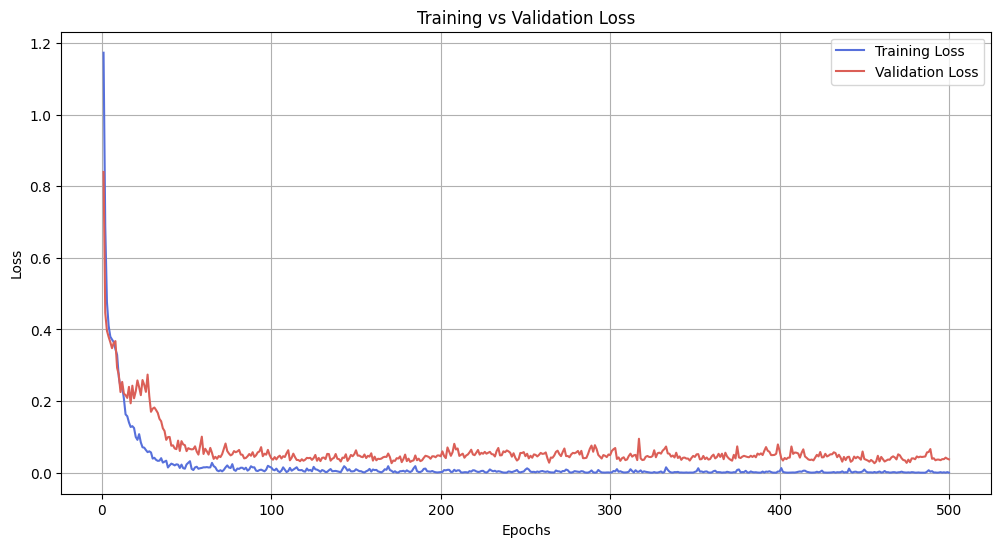

In [ ]:
plt.figure(figsize=(12, 6))
epochs = range(1, num_epochs+1)
hls_palette = sns.color_palette("hls", 8)
sns.lineplot(x=epochs, y=train_losses, label='Training Loss', color=hls_palette[5])
sns.lineplot(x=epochs, y=val_losses, label='Validation Loss', color=hls_palette[0])
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

Train vs validation F1 score

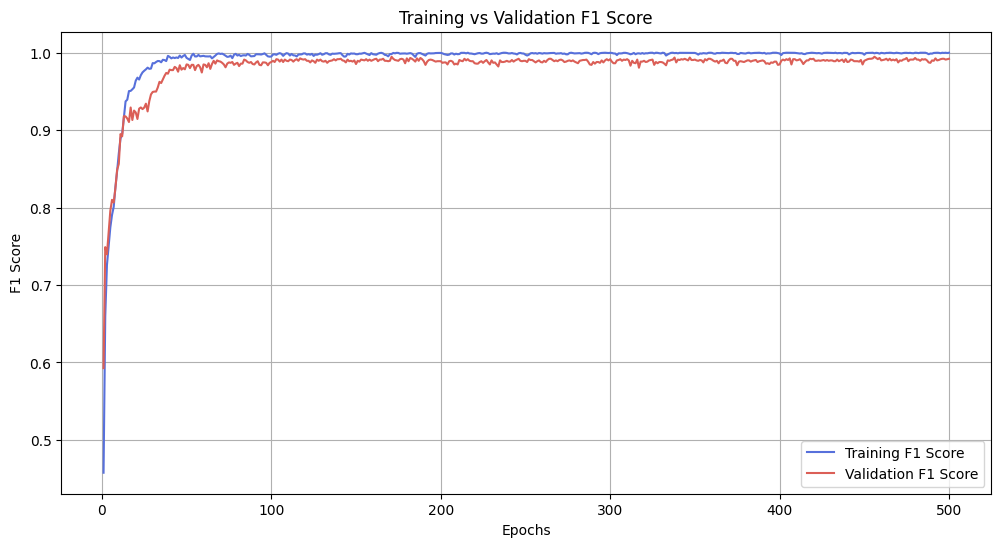

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=epochs, y=train_f1_scores, label='Training F1 Score', color=hls_palette[5])
sns.lineplot(x=epochs, y=val_f1_scores, label='Validation F1 Score', color=hls_palette[0])
plt.title('Training vs Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.grid()
plt.legend()
plt.show()

#### ReLu + BatchSize=256

**Settings**

In [ ]:
# Activation function
activation_fn = torch.relu
batch_size = 256

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model name
ckp_name = f"FC_ReLu_{batch_size}"

# Instantiate the model
model = FCModel(input_size=input_size, num_classes=num_classes, activation_fn=activation_fn).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Train**

In [ ]:
train_f1_scores, train_losses, val_f1_scores, val_losses = train(model=model,
                                                                 num_epochs=num_epochs,
                                                                 train_loader=train_loader,
                                                                 val_loader=val_loader,
                                                                 ckp_name=ckp_name)

[Epoch   1/500] Train Loss: 1.22739819 | Train F1 Score: 0.4326 | Val Loss: 0.87042975 | Val F1 Score: 0.5721
[Epoch  10/500] Train Loss: 0.30414041 | Train F1 Score: 0.8501 | Val Loss: 0.30819215 | Val F1 Score: 0.8406
[Epoch  20/500] Train Loss: 0.09928886 | Train F1 Score: 0.9647 | Val Loss: 0.26159980 | Val F1 Score: 0.9189
[Epoch  30/500] Train Loss: 0.03306180 | Train F1 Score: 0.9906 | Val Loss: 0.24988118 | Val F1 Score: 0.9424
[Epoch  40/500] Train Loss: 0.02915822 | Train F1 Score: 0.9914 | Val Loss: 0.13020640 | Val F1 Score: 0.9676
[Epoch  50/500] Train Loss: 0.01393429 | Train F1 Score: 0.9964 | Val Loss: 0.10144139 | Val F1 Score: 0.9750
[Epoch  60/500] Train Loss: 0.01331235 | Train F1 Score: 0.9960 | Val Loss: 0.07798996 | Val F1 Score: 0.9807
[Epoch  70/500] Train Loss: 0.01507682 | Train F1 Score: 0.9954 | Val Loss: 0.07616698 | Val F1 Score: 0.9802
[Epoch  80/500] Train Loss: 0.00642606 | Train F1 Score: 0.9980 | Val Loss: 0.06742319 | Val F1 Score: 0.9870
[Epoch  90

#### Leaky ReLu + BatchSize=128

**Settings**

In [ ]:
# Activation function
activation_fn = F.leaky_relu
batch_size = 128

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model name
ckp_name = f"FC_leaky_relu_{batch_size}"

# Instantiate the model
model = FCModel(input_size=input_size, num_classes=num_classes, activation_fn=activation_fn).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Train**

In [ ]:
train_f1_scores, train_losses, val_f1_scores, val_losses = train(model=model,
                                                                 num_epochs=num_epochs,
                                                                 train_loader=train_loader,
                                                                 val_loader=val_loader,
                                                                 ckp_name=ckp_name)

[Epoch   1/500] Train Loss: 1.11848515 | Train F1 Score: 0.4747 | Val Loss: 0.85879631 | Val F1 Score: 0.6054
[Epoch  10/500] Train Loss: 0.24913117 | Train F1 Score: 0.8841 | Val Loss: 0.26167717 | Val F1 Score: 0.8875
[Epoch  20/500] Train Loss: 0.08799780 | Train F1 Score: 0.9695 | Val Loss: 0.27509494 | Val F1 Score: 0.9161
[Epoch  30/500] Train Loss: 0.03283462 | Train F1 Score: 0.9901 | Val Loss: 0.17503507 | Val F1 Score: 0.9551
[Epoch  40/500] Train Loss: 0.02175947 | Train F1 Score: 0.9939 | Val Loss: 0.08653491 | Val F1 Score: 0.9781
[Epoch  50/500] Train Loss: 0.00719697 | Train F1 Score: 0.9983 | Val Loss: 0.06237790 | Val F1 Score: 0.9828
[Epoch  60/500] Train Loss: 0.01555887 | Train F1 Score: 0.9956 | Val Loss: 0.06337346 | Val F1 Score: 0.9859
[Epoch  70/500] Train Loss: 0.01463195 | Train F1 Score: 0.9951 | Val Loss: 0.07162484 | Val F1 Score: 0.9781
[Epoch  80/500] Train Loss: 0.01017399 | Train F1 Score: 0.9979 | Val Loss: 0.07468963 | Val F1 Score: 0.9828
[Epoch  90

#### Leaky ReLu + BatchSize=256

**Settings**

In [ ]:
# Activation function
activation_fn = F.leaky_relu
batch_size = 256

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model name
ckp_name = f"FC_leaky_relu_{batch_size}"

# Instantiate the model
model = FCModel(input_size=input_size, num_classes=num_classes, activation_fn=activation_fn).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Train**

In [ ]:
train_f1_scores, train_losses, val_f1_scores, val_losses = train(model=model,
                                                                 num_epochs=num_epochs,
                                                                 train_loader=train_loader,
                                                                 val_loader=val_loader,
                                                                 ckp_name=ckp_name)

[Epoch   1/500] Train Loss: 1.23593732 | Train F1 Score: 0.4267 | Val Loss: 0.88767882 | Val F1 Score: 0.6230
[Epoch  10/500] Train Loss: 0.27605493 | Train F1 Score: 0.8692 | Val Loss: 0.33336145 | Val F1 Score: 0.8293
[Epoch  20/500] Train Loss: 0.07961082 | Train F1 Score: 0.9725 | Val Loss: 0.25185916 | Val F1 Score: 0.9228
[Epoch  30/500] Train Loss: 0.02475273 | Train F1 Score: 0.9914 | Val Loss: 0.15801770 | Val F1 Score: 0.9541
[Epoch  40/500] Train Loss: 0.04566252 | Train F1 Score: 0.9887 | Val Loss: 0.10389353 | Val F1 Score: 0.9749
[Epoch  50/500] Train Loss: 0.01189385 | Train F1 Score: 0.9971 | Val Loss: 0.10541704 | Val F1 Score: 0.9760
[Epoch  60/500] Train Loss: 0.00911306 | Train F1 Score: 0.9971 | Val Loss: 0.07111876 | Val F1 Score: 0.9844
[Epoch  70/500] Train Loss: 0.00630198 | Train F1 Score: 0.9978 | Val Loss: 0.05703631 | Val F1 Score: 0.9864
[Epoch  80/500] Train Loss: 0.01386820 | Train F1 Score: 0.9967 | Val Loss: 0.06776182 | Val F1 Score: 0.9849
[Epoch  90

#### Elu + BatchSize=128

**Settings**

In [ ]:
# Activation function
activation_fn = F.elu
batch_size = 128

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model name
ckp_name = f"FC_elu_{batch_size}"

# Instantiate the model
model = FCModel(input_size=input_size, num_classes=num_classes, activation_fn=activation_fn).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Train**

In [ ]:
train_f1_scores, train_losses, val_f1_scores, val_losses = train(model=model,
                                                                 num_epochs=num_epochs,
                                                                 train_loader=train_loader,
                                                                 val_loader=val_loader,
                                                                 ckp_name=ckp_name)

[Epoch   1/500] Train Loss: 0.90800156 | Train F1 Score: 0.5752 | Val Loss: 0.50461667 | Val F1 Score: 0.7164
[Epoch  10/500] Train Loss: 0.34539563 | Train F1 Score: 0.8255 | Val Loss: 0.31896937 | Val F1 Score: 0.8330
[Epoch  20/500] Train Loss: 0.18909722 | Train F1 Score: 0.9257 | Val Loss: 0.22944842 | Val F1 Score: 0.9092
[Epoch  30/500] Train Loss: 0.11536039 | Train F1 Score: 0.9567 | Val Loss: 0.25556419 | Val F1 Score: 0.9091
[Epoch  40/500] Train Loss: 0.09718334 | Train F1 Score: 0.9629 | Val Loss: 0.24784020 | Val F1 Score: 0.9215
[Epoch  50/500] Train Loss: 0.06791668 | Train F1 Score: 0.9746 | Val Loss: 0.25583598 | Val F1 Score: 0.9163
[Epoch  60/500] Train Loss: 0.05154094 | Train F1 Score: 0.9820 | Val Loss: 0.27960624 | Val F1 Score: 0.9280
[Epoch  70/500] Train Loss: 0.02587629 | Train F1 Score: 0.9908 | Val Loss: 0.23296582 | Val F1 Score: 0.9363
[Epoch  80/500] Train Loss: 0.01625599 | Train F1 Score: 0.9951 | Val Loss: 0.16679653 | Val F1 Score: 0.9572
[Epoch  90

#### Elu + BatchSize=256

**Settings**

In [ ]:
# Activation function
activation_fn = F.elu
batch_size = 256

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model name
ckp_name = f"FC_elu_{batch_size}"

# Instantiate the model
model = FCModel(input_size=input_size, num_classes=num_classes, activation_fn=activation_fn).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Train**

In [ ]:
train_f1_scores, train_losses, val_f1_scores, val_losses = train(model=model,
                                                                 num_epochs=num_epochs,
                                                                 train_loader=train_loader,
                                                                 val_loader=val_loader,
                                                                 ckp_name=ckp_name)

[Epoch   1/500] Train Loss: 0.95195258 | Train F1 Score: 0.5592 | Val Loss: 0.50298162 | Val F1 Score: 0.6894
[Epoch  10/500] Train Loss: 0.32259384 | Train F1 Score: 0.8419 | Val Loss: 0.31656758 | Val F1 Score: 0.8432
[Epoch  20/500] Train Loss: 0.16514959 | Train F1 Score: 0.9372 | Val Loss: 0.21598417 | Val F1 Score: 0.9130
[Epoch  30/500] Train Loss: 0.11381521 | Train F1 Score: 0.9556 | Val Loss: 0.21680838 | Val F1 Score: 0.9189
[Epoch  40/500] Train Loss: 0.06915300 | Train F1 Score: 0.9733 | Val Loss: 0.25277589 | Val F1 Score: 0.9240
[Epoch  50/500] Train Loss: 0.04480972 | Train F1 Score: 0.9825 | Val Loss: 0.21848795 | Val F1 Score: 0.9378
[Epoch  60/500] Train Loss: 0.02114668 | Train F1 Score: 0.9931 | Val Loss: 0.17788919 | Val F1 Score: 0.9499
[Epoch  70/500] Train Loss: 0.01434343 | Train F1 Score: 0.9957 | Val Loss: 0.14464415 | Val F1 Score: 0.9618
[Epoch  80/500] Train Loss: 0.01036975 | Train F1 Score: 0.9961 | Val Loss: 0.10340724 | Val F1 Score: 0.9666
[Epoch  90

### Run all the models on the validation set to analyze all the metrics.

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def validate(model, val_loader, best_ckpt):
    model = model.to(device)
    model.load_state_dict(torch.load(best_ckpt))
    predictions = []
    true_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1).cpu().tolist()
            predictions.extend(preds)
            true_labels.extend(labels.tolist())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')

    return predictions, accuracy, precision, recall, f1

In [ ]:
best_ckp_FC_ReLu_128 = "checkpoints/FC_ReLu_128/FC_ReLu_128_checkpoint_460.pth"
best_ckp_FC_ReLu_256 = "checkpoints/FC_ReLu_256/FC_ReLu_256_checkpoint_163.pth"
best_ckp_FC_leaky_relu_128 = "checkpoints/FC_leaky_relu_128/FC_leaky_relu_128_checkpoint_337.pth"
best_ckp_FC_leaky_relu_256 = "checkpoints/FC_leaky_relu_256/FC_leaky_relu_256_checkpoint_481.pth"
best_ckp_FC_elu_128 = "checkpoints/FC_elu_128/FC_elu_128_checkpoint_487.pth"
best_ckp_FC_elu_256 = "checkpoints/FC_elu_256/FC_elu_256_checkpoint_474.pth"

ckps_FC = [best_ckp_FC_ReLu_128, best_ckp_FC_ReLu_256,
           best_ckp_FC_leaky_relu_128, best_ckp_FC_leaky_relu_256,
           best_ckp_FC_elu_128, best_ckp_FC_elu_256]

In [ ]:
outputs_FC = []
all_metrics_FC = []

for ckp in ckps_FC:

    if "ReLu" in ckp:
        activation_fn = torch.relu
    elif "leaky_relu" in ckp:
        activation_fn = F.leaky_relu
    else:
        activation_fn = F.elu

    model_name = ckp.split('/')[1]
    model = FCModel(input_size=input_size, num_classes=num_classes, activation_fn=activation_fn).to(device)
    preds, accuracy, precision, recall, f1 = validate(model, val_loader, ckp)
    outputs_FC.append(preds)
    metrics = {
        "model": model_name,
        "accuracy": round(accuracy, 4),
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1_score": round(f1, 4)
    }
    all_metrics_FC.append(metrics)

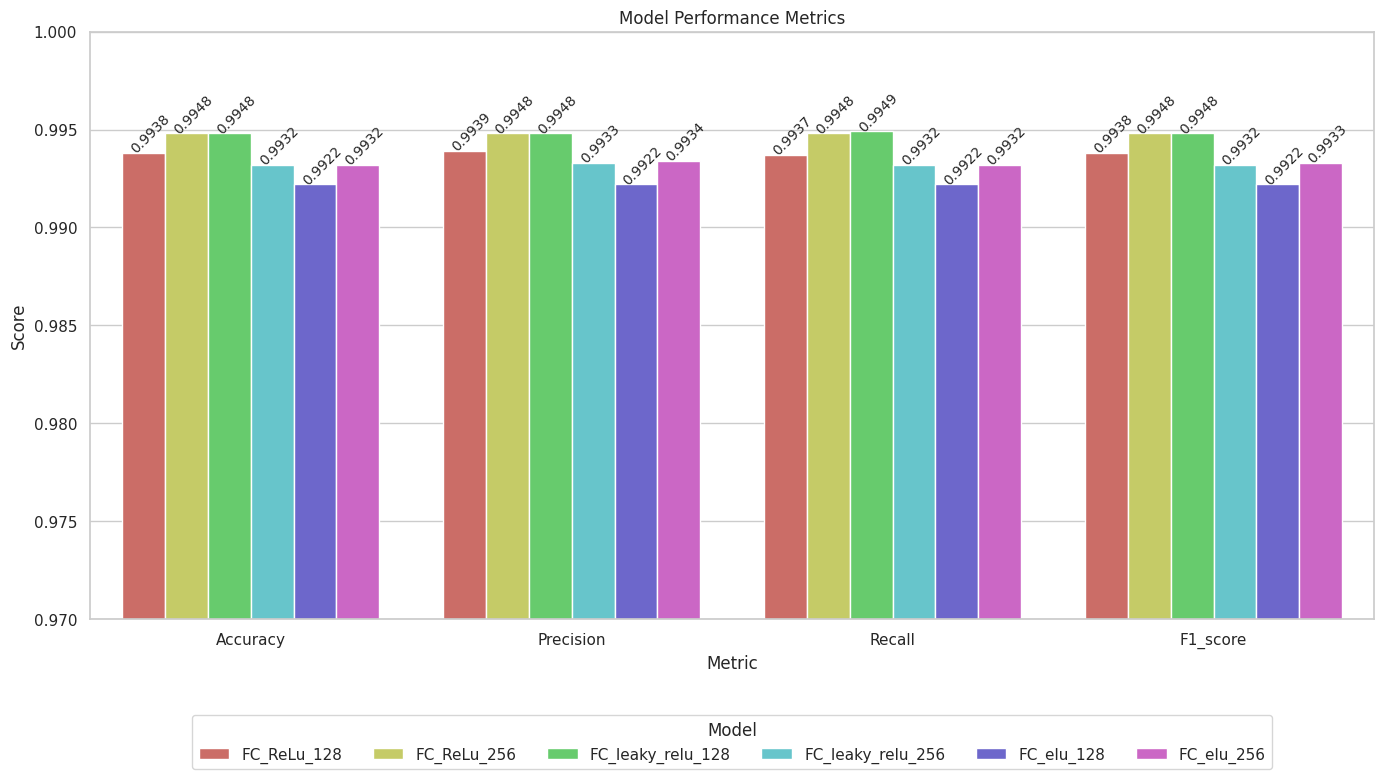

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

data = []
for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
    for m in all_metrics_FC:
        data.append({
            'Model': m['model'],
            'Metric': metric.capitalize(),
            'Score': m[metric]
        })
df = pd.DataFrame(data)

plt.figure(figsize=(14, 8))
plot = sns.barplot(x='Metric', y='Score', hue='Model', data=df, palette='hls')

for p in plot.patches:
    height = p.get_height()
    plot.annotate(format(height, '.4f'),
                  (p.get_x() + p.get_width() / 2., height),
                  ha = 'center', va = 'center',
                  xytext = (5, 14),
                  textcoords = 'offset points',
                  rotation = 45,
                  fontsize = 10)

plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')

plt.ylim([0.97, 1.0])

plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(all_metrics))

plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter
import numpy as np

def ensemble_predictions(prediction_lists):
    # Transpose the list of predictions to iterate over each sample
    transposed_predictions = np.array(prediction_lists).T

    # For each sample, count the votes for each class and pick the one with the most votes
    final_predictions = [Counter(sample_predictions).most_common(1)[0][0] for sample_predictions in transposed_predictions]

    return final_predictions

Ensemble all the predictions.

In [ ]:
predictions_FC = ensemble_predictions(outputs_FC)

accuracy_FC = accuracy_score(true_labels, predictions_FC)
precision_FC = precision_score(true_labels, predictions_FC, average='macro')
recall_FC = recall_score(true_labels, predictions_FC, average='macro')
f1_FC = f1_score(true_labels, predictions_FC, average='macro')

### Predict on the test set

In [ ]:
file_path = 'dataset_test_no_label.csv'
X_test = pd.read_csv(file_path, header=None, index_col=0)

new_column_names = [f'V{i}' for i in range(257)]
X_test.columns = new_column_names

print(f'Dataset dimension: {X_test.shape}\n')
display(X_test[['V0', 'V1', 'V2', 'V254', 'V255', 'V256']].head(10))

Dataset dimension: (2400, 257)



,V0,V1,V2,V254,V255,V256
0,,,,,,
0,-0.007331,-0.007335,-0.007424,0.004648,0.005196,18
1,0.006343,0.008246,0.009503,0.002968,0.002314,16
2,0.008270,0.008264,0.007274,0.007087,0.006963,18
3,-0.003600,-0.004179,-0.004818,0.007832,0.008063,18
4,0.004008,0.004021,0.003951,-0.006587,-0.006705,18
5,0.006598,0.006606,0.006612,-0.004248,-0.004565,10
6,-0.007682,-0.007479,-0.007231,0.002186,0.002248,10
7,-0.008715,-0.006983,-0.004807,0.008237,0.008798,16
8,-0.000902,-0.000571,-0.000545,-0.001063,0.000336,16


In [ ]:
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Creating dataloaders
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
def test(model, best_ckpt):
    model = model.to(device)
    model.load_state_dict(torch.load(best_ckpt))
    predictions = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().tolist())

    return predictions

In [ ]:
outputs_FC_test = []

for ckp in ckps_FC:

    if "ReLu" in ckp:
        activation_fn = torch.relu
    elif "leaky_relu" in ckp:
        activation_fn = F.leaky_relu
    else:
        activation_fn = F.elu

    model = FCModel(input_size=input_size, num_classes=num_classes, activation_fn=activation_fn).to(device)
    probabilities = test(model, ckp)
    outputs_FC_test.append(probabilities)

In [ ]:
final_class_predictions = ensemble_predictions(outputs_FC_test)

In [ ]:
def save_pred(pred, csv_file_path):
    original_labels = le.inverse_transform(pred)
    predictions_df = pd.DataFrame(range(len(original_labels)), columns=['ID'])
    predictions_df['Class'] = original_labels
    predictions_df.to_csv(csv_file_path, index=False)
    print(f"Predictions saved to {csv_file_path}")

In [ ]:
csv_file_path = 'Predictions/ensemble_CNN_2.csv'
save_pred(final_class_predictions, csv_file_path)

Predictions saved to Predictions/ensemble_CNN_2.csv


## Attempt 3: Convolutional Neural Network 

### Define the model

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_channels, num_classes, d_model=1024, activation_fn=torch.relu, dropout_rate=0.5):
        super(CNNModel, self).__init__()

        self.activation_fn = activation_fn
        # Define the convolutional layers
        self.conv_layers = nn.ModuleDict({
            'conv3': nn.Conv1d(num_channels, d_model, 3, padding=1),
            'conv5': nn.Conv1d(num_channels, d_model, 5, padding=2)
        })

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Additional layers
        self.bn1 = nn.BatchNorm1d(d_model*2)
        self.conv2 = nn.Conv1d(d_model*2, d_model*2, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(d_model*2)
        self.pool1 = nn.MaxPool1d(2, 2)
        self.conv3 = nn.Conv1d(d_model*2, d_model*2, 3, padding=1)
        self.bn3 = nn.BatchNorm1d(d_model*2)
        self.conv4 = nn.Conv1d(d_model, d_model, 3, padding=1)
        self.bn4 = nn.BatchNorm1d(d_model)
        self.conv5 = nn.Conv1d(d_model, d_model//2, 3, padding=1)
        self.bn5 = nn.BatchNorm1d(d_model//2)
        self.pool2 = nn.MaxPool1d(2, 2)
        self.conv6 = nn.Conv1d(d_model//2, d_model//2, 3, padding=1)
        self.bn6 = nn.BatchNorm1d(d_model//2)
        self.conv7 = nn.Conv1d(d_model//2, d_model//4, 3, padding=1)
        self.bn7 = nn.BatchNorm1d(d_model//4)
        self.conv8 = nn.Conv1d(d_model//4, d_model//4, 3, padding=1)
        self.bn8 = nn.BatchNorm1d(d_model//4)
        self.fc1 = nn.Linear(d_model//4, d_model//8)
        self.fc2 = nn.Linear(d_model//8, num_classes)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = x.permute(1, 0)
        # Initial parallel processing
        conv3_output = self.activation_fn(self.conv_layers['conv3'](x))
        conv5_output = self.activation_fn(self.conv_layers['conv5'](x))
        x = self.bn1(torch.cat([conv3_output, conv5_output], dim=0).permute(1, 0)).permute(1, 0)

        # Apply first set of layers with residual connection and dropout
        residual = x
        x = self.activation_fn(self.bn2(self.conv2(x).permute(1, 0)).permute(1, 0))
        x = self.dropout(x)
        x += residual

        # Continue with the rest of the network
        x = self.activation_fn(self.bn3(self.conv3(x).permute(1, 0)).permute(1, 0))
        x = self.pool1(x.permute(1, 0))
        x = self.dropout(x.permute(1, 0))
        x = self.activation_fn(self.bn4(self.conv4(x).permute(1, 0)).permute(1, 0))
        residual = self.pool2(x.permute(1, 0))
        x = self.activation_fn(self.bn5(self.conv5(x).permute(1, 0)).permute(1, 0))
        x = x + residual.permute(1, 0)
        x = self.dropout(x)
        x = self.activation_fn(self.bn6(self.conv6(x).permute(1, 0)).permute(1, 0))
        x = self.activation_fn(self.bn7(self.conv7(x).permute(1, 0)).permute(1, 0))
        x = self.activation_fn(self.bn8(self.conv8(x).permute(1, 0)))
        x = self.dropout(x)
        x = self.activation_fn(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
model = CNNModel(num_channels=num_channels, num_classes=num_classes)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters:", total_params)
del model

Number of parameters: 33425540


### Define the training function

In [ ]:
def train(model, num_epochs, train_loader, val_loader, ckp_name):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_accuracy = 0
    best_epoch = None

    # Training the Neural Network
    for epoch in range(num_epochs):
        # For training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # For validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_losses.append(running_val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), f'checkpoints/{ckp_name}/{ckp_name}_checkpoint_{epoch+1}.pth')

        # Print results
        if (epoch+1)%10 == 0 or epoch == 0:
          print(f"\033[1m[Epoch {epoch+1:3.0f}/{num_epochs}]\033[0m "
                f"Train Loss: {train_losses[-1]:.8f} | "
                f"Train Accuracy: {train_accuracies[-1]:.4f} | "
                f"Val Loss: {val_losses[-1]:.8f} | "
                f"Val Accuracy: {val_accuracies[-1]:.4f}")

    print(f"\n\033[1mBest checkpoints:\033[0m checkpoints/{ckp_name}/{ckp_name}_checkpoint_{best_epoch+1}.pth")
    return train_accuracies, train_losses, val_accuracies, val_losses

### Try different hyperpameteres to then ensemble the results

#### ReLu + BatchSize=128

**Settings**

In [ ]:
# Activation function
activation_fn = torch.relu
batch_size = 128

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model name
ckp_name = f"CNN_ReLu_{batch_size}"

# Instantiate the model
model = CNNModel(num_channels=num_channels, num_classes=num_classes, activation_fn=activation_fn).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Train**

In [ ]:
train_accuracies, train_losses, val_accuracies, val_losses = train(model=model,
                                                                   num_epochs=num_epochs,
                                                                   train_loader=train_loader,
                                                                   val_loader=val_loader,
                                                                   ckp_name=ckp_name)

[Epoch   1/1000] Train Loss: 0.97790555 | Train Accuracy: 0.5125 | Val Loss: 0.96190540 | Val Accuracy: 0.5682
[Epoch  10/1000] Train Loss: 0.51957886 | Train Accuracy: 0.7129 | Val Loss: 0.48132025 | Val Accuracy: 0.7302
[Epoch  20/1000] Train Loss: 0.44055126 | Train Accuracy: 0.7380 | Val Loss: 0.41700229 | Val Accuracy: 0.7615
[Epoch  30/1000] Train Loss: 0.40121633 | Train Accuracy: 0.7578 | Val Loss: 0.40845510 | Val Accuracy: 0.7740
[Epoch  40/1000] Train Loss: 0.37697703 | Train Accuracy: 0.7966 | Val Loss: 0.36868890 | Val Accuracy: 0.8036
[Epoch  50/1000] Train Loss: 0.30329017 | Train Accuracy: 0.8529 | Val Loss: 0.31416299 | Val Accuracy: 0.8406
[Epoch  60/1000] Train Loss: 0.27445020 | Train Accuracy: 0.8684 | Val Loss: 0.30222176 | Val Accuracy: 0.8536
[Epoch  70/1000] Train Loss: 0.24755078 | Train Accuracy: 0.8845 | Val Loss: 0.31583290 | Val Accuracy: 0.8531
[Epoch  80/1000] Train Loss: 0.20480487 | Train Accuracy: 0.9142 | Val Loss: 0.27500014 | Val Accuracy: 0.8859
[

Loss train vs validation

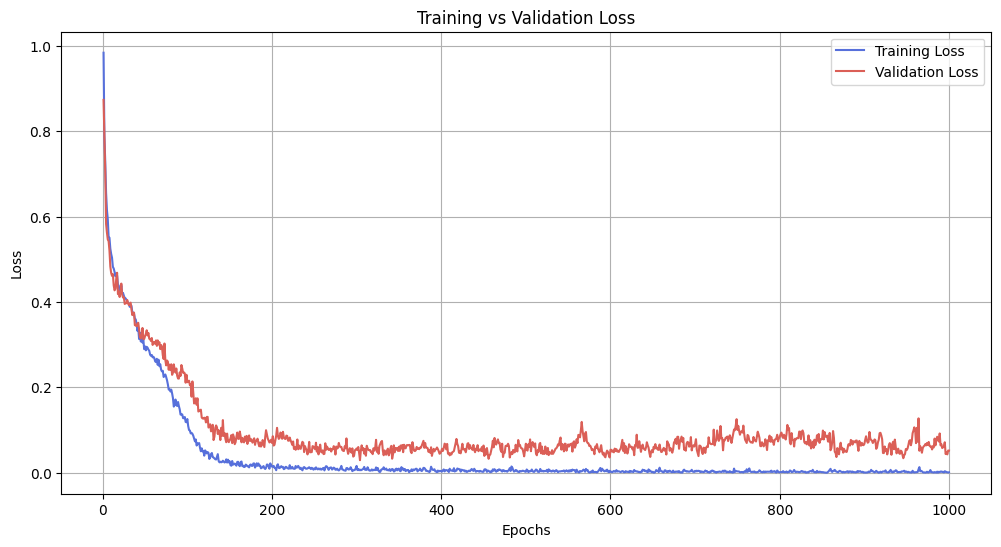

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
epochs = range(1, num_epochs+1)
hls_palette = sns.color_palette("hls", 8)
sns.lineplot(x=epochs, y=train_losses, label='Training Loss', color=hls_palette[5])
sns.lineplot(x=epochs, y=val_losses, label='Validation Loss', color=hls_palette[0])
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

Accuracy train vs validation

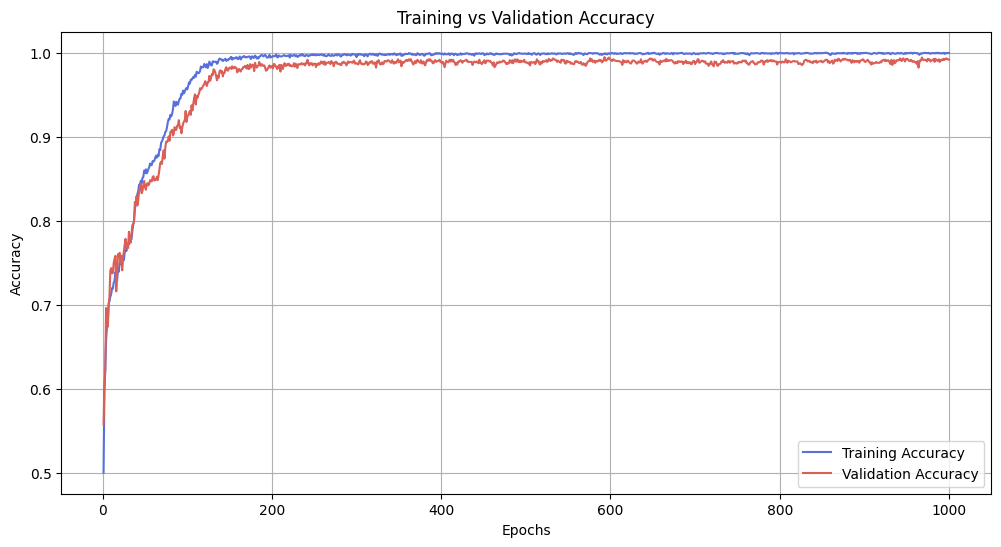

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=epochs, y=train_accuracies, label='Training Accuracy', color=hls_palette[5])
sns.lineplot(x=epochs, y=val_accuracies, label='Validation Accuracy', color=hls_palette[0])
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

#### ReLu + BatchSize=256

**Settings**

In [ ]:
# Activation function
activation_fn = torch.relu
batch_size = 256

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model name
ckp_name = f"CNN_ReLu_{batch_size}"

# Instantiate the model
model = CNNModel(num_channels=num_channels, num_classes=num_classes, activation_fn=activation_fn).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Train**

In [ ]:
train_accuracies, train_losses, val_accuracies, val_losses = train(model=model,
                                                                   num_epochs=num_epochs,
                                                                   train_loader=train_loader,
                                                                   val_loader=val_loader,
                                                                   ckp_name=ckp_name)

[Epoch   1/1000] Train Loss: 1.06374189 | Train Accuracy: 0.4681 | Val Loss: 1.38722482 | Val Accuracy: 0.4495
[Epoch  10/1000] Train Loss: 0.49956847 | Train Accuracy: 0.7216 | Val Loss: 0.47823196 | Val Accuracy: 0.7380
[Epoch  20/1000] Train Loss: 0.43193032 | Train Accuracy: 0.7518 | Val Loss: 0.43091500 | Val Accuracy: 0.7568
[Epoch  30/1000] Train Loss: 0.39410718 | Train Accuracy: 0.7639 | Val Loss: 0.40306347 | Val Accuracy: 0.7354
[Epoch  40/1000] Train Loss: 0.36178725 | Train Accuracy: 0.8023 | Val Loss: 0.37302567 | Val Accuracy: 0.7969
[Epoch  50/1000] Train Loss: 0.29402315 | Train Accuracy: 0.8589 | Val Loss: 0.31795938 | Val Accuracy: 0.8375
[Epoch  60/1000] Train Loss: 0.25889372 | Train Accuracy: 0.8785 | Val Loss: 0.30514923 | Val Accuracy: 0.8630
[Epoch  70/1000] Train Loss: 0.21485167 | Train Accuracy: 0.9142 | Val Loss: 0.24876516 | Val Accuracy: 0.8932
[Epoch  80/1000] Train Loss: 0.17022380 | Train Accuracy: 0.9368 | Val Loss: 0.23647406 | Val Accuracy: 0.9057
[

#### Leaky ReLu + BatchSize=128

**Settings**

In [ ]:
# Activation function
activation_fn = F.leaky_relu
batch_size = 128

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model name
ckp_name = f"CNN_leaky_relu_{batch_size}"

# Instantiate the model
model = CNNModel(num_channels=num_channels, num_classes=num_classes, activation_fn=activation_fn).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Train**

In [ ]:
train_accuracies, train_losses, val_accuracies, val_losses = train(model=model,
                                                                   num_epochs=num_epochs,
                                                                   train_loader=train_loader,
                                                                   val_loader=val_loader,
                                                                   ckp_name=ckp_name)

[Epoch   1/1000] Train Loss: 0.98345096 | Train Accuracy: 0.4990 | Val Loss: 0.98682733 | Val Accuracy: 0.5240
[Epoch  10/1000] Train Loss: 0.51213634 | Train Accuracy: 0.7085 | Val Loss: 0.51175228 | Val Accuracy: 0.6880
[Epoch  20/1000] Train Loss: 0.43339015 | Train Accuracy: 0.7461 | Val Loss: 0.40333769 | Val Accuracy: 0.7599
[Epoch  30/1000] Train Loss: 0.41103318 | Train Accuracy: 0.7661 | Val Loss: 0.40616026 | Val Accuracy: 0.7682
[Epoch  40/1000] Train Loss: 0.35666189 | Train Accuracy: 0.8232 | Val Loss: 0.35155322 | Val Accuracy: 0.8099
[Epoch  50/1000] Train Loss: 0.29081752 | Train Accuracy: 0.8595 | Val Loss: 0.30121020 | Val Accuracy: 0.8391
[Epoch  60/1000] Train Loss: 0.26824365 | Train Accuracy: 0.8703 | Val Loss: 0.29469864 | Val Accuracy: 0.8536
[Epoch  70/1000] Train Loss: 0.25254320 | Train Accuracy: 0.8786 | Val Loss: 0.29893011 | Val Accuracy: 0.8547
[Epoch  80/1000] Train Loss: 0.21416753 | Train Accuracy: 0.9115 | Val Loss: 0.26109943 | Val Accuracy: 0.8948
[

#### Leaky ReLu + BatchSize=256

**Settings**

In [ ]:
train_accuracies, train_losses, val_accuracies, val_losses = train(model=model,
                                                                   num_epochs=num_epochs,
                                                                   train_loader=train_loader,
                                                                   val_loader=val_loader,
                                                                   ckp_name=ckp_name)

**Train**

In [ ]:
train(model=model,
      num_epochs=num_epochs,
      activation_fn=activation_fn,
      train_loader=train_loader,
      val_loader=val_loader,
      ckp_name=ckp_name)

[Epoch   1/1000] Train Loss: 1.06973897 | Train Accuracy: 0.4655 | Val Loss: 1.60679954 | Val Accuracy: 0.4193
[Epoch  10/1000] Train Loss: 0.51267893 | Train Accuracy: 0.7087 | Val Loss: 0.49613762 | Val Accuracy: 0.7333
[Epoch  20/1000] Train Loss: 0.42825989 | Train Accuracy: 0.7491 | Val Loss: 0.43118396 | Val Accuracy: 0.7469
[Epoch  30/1000] Train Loss: 0.40254100 | Train Accuracy: 0.7635 | Val Loss: 0.41077698 | Val Accuracy: 0.7406
[Epoch  40/1000] Train Loss: 0.38121039 | Train Accuracy: 0.7853 | Val Loss: 0.40672489 | Val Accuracy: 0.7708
[Epoch  50/1000] Train Loss: 0.30993046 | Train Accuracy: 0.8460 | Val Loss: 0.32891191 | Val Accuracy: 0.8281
[Epoch  60/1000] Train Loss: 0.26952786 | Train Accuracy: 0.8717 | Val Loss: 0.32131045 | Val Accuracy: 0.8505
[Epoch  70/1000] Train Loss: 0.23743295 | Train Accuracy: 0.8977 | Val Loss: 0.29187514 | Val Accuracy: 0.8760
[Epoch  80/1000] Train Loss: 0.18379246 | Train Accuracy: 0.9267 | Val Loss: 0.23916517 | Val Accuracy: 0.9057
[

#### Elu + BatchSize=128

**Settings**

In [ ]:
# Activation function
activation_fn = F.elu
batch_size = 128

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model name
ckp_name = f"CNN_elu_{batch_size}"

# Instantiate the model
model = CNNModel(num_channels=num_channels, num_classes=num_classes, activation_fn=activation_fn).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Train**

In [ ]:
train_accuracies, train_losses, val_accuracies, val_losses = train(model=model,
                                                                   num_epochs=num_epochs,
                                                                   train_loader=train_loader,
                                                                   val_loader=val_loader,
                                                                   ckp_name=ckp_name)

[Epoch   1/1000] Train Loss: 0.93586150 | Train Accuracy: 0.5335 | Val Loss: 0.97299866 | Val Accuracy: 0.5411
[Epoch  10/1000] Train Loss: 0.54625961 | Train Accuracy: 0.7178 | Val Loss: 0.53275175 | Val Accuracy: 0.7271
[Epoch  20/1000] Train Loss: 0.44830942 | Train Accuracy: 0.7711 | Val Loss: 0.45215038 | Val Accuracy: 0.7615
[Epoch  30/1000] Train Loss: 0.37816251 | Train Accuracy: 0.8138 | Val Loss: 0.37968358 | Val Accuracy: 0.8021
[Epoch  40/1000] Train Loss: 0.32187469 | Train Accuracy: 0.8436 | Val Loss: 0.32862645 | Val Accuracy: 0.8438
[Epoch  50/1000] Train Loss: 0.29550661 | Train Accuracy: 0.8608 | Val Loss: 0.31621941 | Val Accuracy: 0.8406
[Epoch  60/1000] Train Loss: 0.25547578 | Train Accuracy: 0.8794 | Val Loss: 0.30301611 | Val Accuracy: 0.8568
[Epoch  70/1000] Train Loss: 0.21456579 | Train Accuracy: 0.9104 | Val Loss: 0.28114701 | Val Accuracy: 0.8776
[Epoch  80/1000] Train Loss: 0.17175492 | Train Accuracy: 0.9336 | Val Loss: 0.26298879 | Val Accuracy: 0.8948
[

#### Elu + BatchSize=256

**Settings**

In [ ]:
# Activation function
activation_fn = F.elu
batch_size = 256

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model name
ckp_name = f"CNN_elu_{batch_size}"

# Instantiate the model
model = CNNModel(num_channels=num_channels, num_classes=num_classes, activation_fn=activation_fn).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Train**

In [ ]:
train_accuracies, train_losses, val_accuracies, val_losses = train(model=model,
                                                                   num_epochs=num_epochs,
                                                                   train_loader=train_loader,
                                                                   val_loader=val_loader,
                                                                   ckp_name=ckp_name)

[Epoch   1/1000] Train Loss: 0.96598516 | Train Accuracy: 0.5091 | Val Loss: 1.86924729 | Val Accuracy: 0.3635
[Epoch  10/1000] Train Loss: 0.54023675 | Train Accuracy: 0.7234 | Val Loss: 0.51875825 | Val Accuracy: 0.7500
[Epoch  20/1000] Train Loss: 0.44887019 | Train Accuracy: 0.7783 | Val Loss: 0.44299329 | Val Accuracy: 0.7854
[Epoch  30/1000] Train Loss: 0.38509464 | Train Accuracy: 0.8143 | Val Loss: 0.40488666 | Val Accuracy: 0.8010
[Epoch  40/1000] Train Loss: 0.34054035 | Train Accuracy: 0.8400 | Val Loss: 0.36160537 | Val Accuracy: 0.8302
[Epoch  50/1000] Train Loss: 0.29965028 | Train Accuracy: 0.8583 | Val Loss: 0.33090996 | Val Accuracy: 0.8427
[Epoch  60/1000] Train Loss: 0.27131421 | Train Accuracy: 0.8715 | Val Loss: 0.31236138 | Val Accuracy: 0.8490
[Epoch  70/1000] Train Loss: 0.23025061 | Train Accuracy: 0.8999 | Val Loss: 0.29100923 | Val Accuracy: 0.8776
[Epoch  80/1000] Train Loss: 0.18907893 | Train Accuracy: 0.9251 | Val Loss: 0.29474279 | Val Accuracy: 0.8823
[

### Analysis of the results on the validation set

In [ ]:
batch_size = 128
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

true_labels = []

for inputs, labels in val_loader:
    true_labels.extend(labels.numpy())

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def validate(model, val_loader, best_ckpt):
    model = model.to(device)
    model.load_state_dict(torch.load(best_ckpt))
    predictions = []
    true_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1).cpu().tolist()
            predictions.extend(preds)
            true_labels.extend(labels.tolist())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')

    return predictions, accuracy, precision, recall, f1

In [ ]:
best_ckp_CNN_ReLu_128 = "checkpoints/CNN_ReLu_128/CNN_ReLu_128_checkpoint_660.pth"
best_ckp_CNN_ReLu_256 = "checkpoints/CNN_ReLu_256/CNN_ReLu_256_checkpoint_663.pth"
best_ckp_CNN_leaky_relu_128 = "checkpoints/CNN_leaky_relu_128/CNN_leaky_relu_128_checkpoint_895.pth"
best_ckp_CNN_leaky_relu_256 = "checkpoints/CNN_leaky_relu_256/CNN_leaky_relu_256_checkpoint_790.pth"
best_ckp_CNN_elu_128 = "checkpoints/CNN_elu_128/CNN_elu_128_checkpoint_913.pth"
best_ckp_CNN_elu_256 = "checkpoints/CNN_elu_256/CNN_elu_256_checkpoint_996.pth"

ckps = [best_ckp_CNN_ReLu_128, best_ckp_CNN_ReLu_256,
        best_ckp_CNN_leaky_relu_128, best_ckp_CNN_leaky_relu_256,
        best_ckp_CNN_elu_128, best_ckp_CNN_elu_256]

In [ ]:
outputs = []
all_metrics = []

for ckp in ckps:

    if "ReLu" in ckp:
        activation_fn = torch.relu
    elif "leaky_relu" in ckp:
        activation_fn = F.leaky_relu
    else:
        activation_fn = F.elu

    model_name = ckp.split('/')[1]
    model = CNNModel(num_channels=num_channels, num_classes=num_classes, activation_fn=activation_fn).to(device)
    preds, accuracy, precision, recall, f1 = validate(model, val_loader, ckp)
    outputs.append(preds)
    metrics = {
        "model": model_name,
        "accuracy": round(accuracy, 4),
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1_score": round(f1, 4)
    }
    all_metrics.append(metrics)

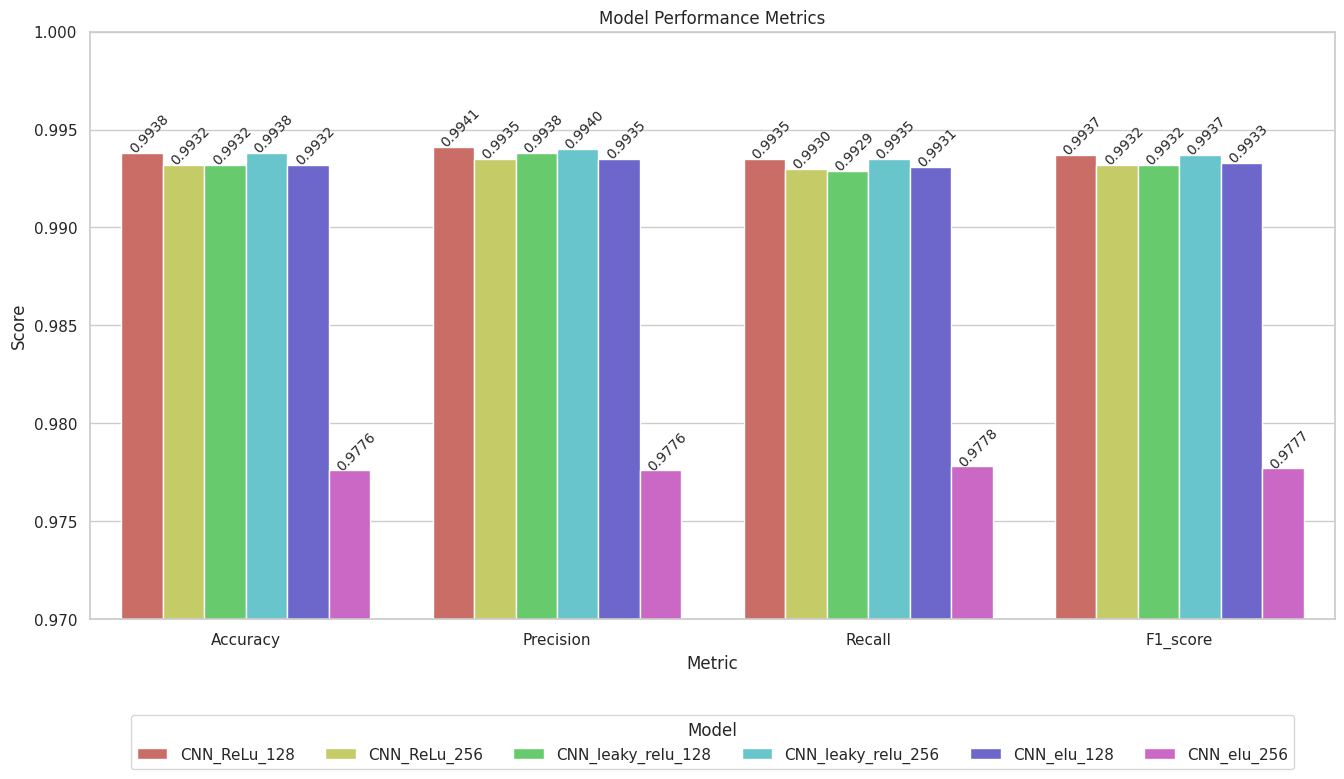

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

# Prepare data for seaborn
data = []
for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
    for m in all_metrics:
        data.append({
            'Model': m['model'],
            'Metric': metric.capitalize(),
            'Score': m[metric]
        })
df = pd.DataFrame(data)

plt.figure(figsize=(14, 8))
plot = sns.barplot(x='Metric', y='Score', hue='Model', data=df, palette='hls')

# Adding the score text on top of each bar
for p in plot.patches:
    height = p.get_height()
    plot.annotate(format(height, '.4f'),
                  (p.get_x() + p.get_width() / 2., height),
                  ha = 'center', va = 'center',
                  xytext = (5, 14),
                  textcoords = 'offset points',
                  rotation = 45,
                  fontsize = 10)

plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')

plt.ylim([0.97, 1.0])

plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(all_metrics))

plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter
import numpy as np

def ensemble_predictions(prediction_lists):
    # Transpose the list of predictions to iterate over each sample
    transposed_predictions = np.array(prediction_lists).T

    # For each sample, count the votes for each class and pick the one with the most votes
    final_predictions = [Counter(sample_predictions).most_common(1)[0][0] for sample_predictions in transposed_predictions]

    return final_predictions

Ensemble the predictions excluding `CNN_elu_256` since it has lower performance.

In [ ]:
predictions_CNN = ensemble_predictions(outputs[0:5])

accuracy_CNN = accuracy_score(true_labels, predictions_CNN)
precision_CNN = precision_score(true_labels, predictions_CNN, average='macro')
recall_CNN = recall_score(true_labels, predictions_CNN, average='macro')
f1_CNN = f1_score(true_labels, predictions_CNN, average='macro')

### Predict on the test set

In [ ]:
file_path = 'dataset_test_no_label.csv'
X_test = pd.read_csv(file_path, header=None, index_col=0)

new_column_names = [f'V{i}' for i in range(257)]
X_test.columns = new_column_names

print(f'Dataset dimension: {X_test.shape}\n')
display(X_test[['V0', 'V1', 'V2', 'V254', 'V255', 'V256']].head(10))

Dataset dimension: (2400, 257)



,V0,V1,V2,V254,V255,V256
0,,,,,,
0,-0.007331,-0.007335,-0.007424,0.004648,0.005196,18
1,0.006343,0.008246,0.009503,0.002968,0.002314,16
2,0.008270,0.008264,0.007274,0.007087,0.006963,18
3,-0.003600,-0.004179,-0.004818,0.007832,0.008063,18
4,0.004008,0.004021,0.003951,-0.006587,-0.006705,18
5,0.006598,0.006606,0.006612,-0.004248,-0.004565,10
6,-0.007682,-0.007479,-0.007231,0.002186,0.002248,10
7,-0.008715,-0.006983,-0.004807,0.008237,0.008798,16
8,-0.000902,-0.000571,-0.000545,-0.001063,0.000336,16


In [ ]:
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Creating dataloaders
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
def test(model, best_ckpt):
    model = model.to(device)
    model.load_state_dict(torch.load(best_ckpt))
    predictions = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().tolist())

    return predictions

In [ ]:
outputs_test = []

for ckp in ckps:

    if "ReLu" in ckp:
        activation_fn = torch.relu
    elif "leaky_relu" in ckp:
        activation_fn = F.leaky_relu
    else:
        activation_fn = F.elu

    model = CNNModel(num_channels=num_channels, num_classes=num_classes, activation_fn=activation_fn).to(device)
    probabilities = test(model, ckp)
    outputs_test.append(probabilities)

In [ ]:
final_class_predictions = ensemble_predictions(outputs_test)

In [ ]:
def save_pred(pred, csv_file_path):
    original_labels = le.inverse_transform(pred)
    predictions_df = pd.DataFrame(range(len(original_labels)), columns=['ID'])
    predictions_df['Class'] = original_labels
    predictions_df.to_csv(csv_file_path, index=False)
    print(f"Predictions saved to {csv_file_path}")

In [ ]:
csv_file_path = 'Predictions/ensemble_2.csv'
save_pred(final_class_predictions, csv_file_path)

Predictions saved to Predictions/ensemble_2.csv


## Attempt 3: Ensemble FC and CNN

### Using the validation set to check the performances

In [ ]:
final_outputs_val = []
final_outputs_val.extend(outputs)
final_outputs_val.extend(outputs_FC)

predictions_FC_CNN = ensemble_predictions(final_outputs_val)

accuracy_FC_CNN = accuracy_score(true_labels, predictions_FC_CNN)
precision_FC_CNN = precision_score(true_labels, predictions_FC_CNN, average='macro')
recall_FC_CNN = recall_score(true_labels, predictions_FC_CNN, average='macro')
f1_FC_CNN = f1_score(true_labels, predictions_FC_CNN, average='macro')

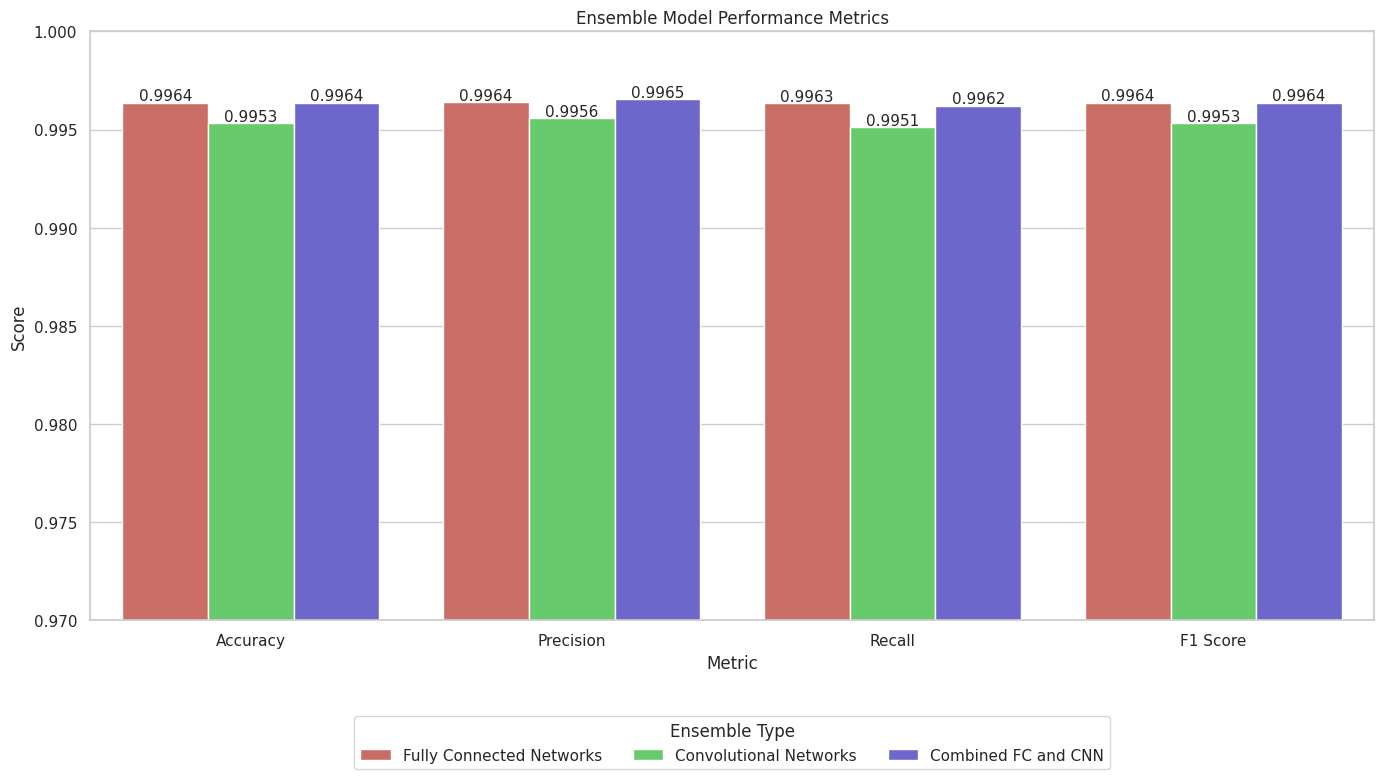

In [ ]:
# Preparing the DataFrame
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'] * 3,
    'Value': [accuracy_FC, precision_FC, recall_FC, f1_FC,
              accuracy_CNN, precision_CNN, recall_CNN, f1_CNN,
              accuracy_FC_CNN, precision_FC_CNN, recall_FC_CNN, f1_FC_CNN],
    'Ensemble Type': ['Fully Connected Networks'] * 4 +
                      ['Convolutional Networks'] * 4 +
                      ['Combined FC and CNN'] * 4
}

df = pd.DataFrame(data)

# Creating the bar plot
plt.figure(figsize=(14, 8))
plot = sns.barplot(x='Metric', y='Value', hue='Ensemble Type', data=df, palette='hls')

for p in plot.patches:
    height = p.get_height()
    plot.annotate(format(height, '.4f'),
                  (p.get_x() + p.get_width() / 2., height),
                  ha = 'center', va = 'center',
                  xytext = (0, 5),
                  textcoords = 'offset points',
                  #rotation = 45,
                  fontsize = 11)

plt.title('Ensemble Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')

plt.ylim([0.97, 1.0])

# Moving the legend outside of the plot
plt.legend(title='Ensemble Type', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(all_metrics))

plt.tight_layout()
plt.show()

### Using the test set to make the final predictions

In [ ]:
final_outputs = []
final_outputs.extend(outputs_test)
final_outputs.extend(outputs_FC_test)

In [ ]:
predictions_FC_CNN = ensemble_predictions(final_outputs)

In [ ]:
csv_file_path = 'Predictions/ensemble_CNN_FC_2.csv'
save_pred(predictions_FC_CNN, csv_file_path)

Predictions saved to Predictions/ensemble_CNN_FC_2.csv
